In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np, scipy as sp, scipy.stats, os, sys, joblib
import os, numpy as np, scipy as sp, scipy.io, scipy.io.wavfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import class_weight
import random
import pandas as pd
import importlib
import useful_functions
import preprocessing_functions
import Chatgpt_model
import results_functions
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-07-12 10:23:51.750426: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 10:23:51.771111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 10:23:52.114532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-07-12 10:23:53.499811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 10:23:53.500286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 10:23:53.500340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
importlib.reload(useful_functions)
importlib.reload(preprocessing_functions)
importlib.reload(Chatgpt_model)
from useful_functions import *
from preprocessing_functions import *
from Chatgpt_model import *

In [3]:
 # Define the data and model foldes.
data_folder = r"../training_data"
model_folder = r"../model"
wind_size = 6000
verbose = 3

In [4]:
recordings,patient_label,patient_id = create_rec_patient_list(data_folder)
df = build_dataset_df(recordings,patient_id,patient_label,wind_size)
df.head()

,patient_id,recording_type,recording,murmur
0,2530.0,1.0,"[254.62053374948147, 332.41397606699405, -727....",0.0
1,2530.0,1.0,"[20.550841480663475, -18.884669077279337, 152....",0.0
2,2530.0,1.0,"[2296.0082592261, 1161.8953810714854, 106.9764...",0.0
3,2530.0,1.0,"[-1.2132347511973676, -24.042684343382245, -14...",0.0
4,2530.0,1.0,"[219.40892010033423, 106.21377642082071, 296.9...",0.0


In [5]:
# check correctness of dataframe loaded
for i in range(df.shape[0]):
  if len(df["recording"][i]) != wind_size:
    print("problem sir")

In [6]:
# select only two columns
new_df = df[['patient_id', 'murmur']]
new_df = new_df.drop_duplicates()
new_df = new_df.reset_index(drop=True)

In [7]:
# check murmur/non-murmur balance
nb_murmur_present = (new_df.loc[new_df['murmur'] == 1]).shape[0]
nb_murmur_absent = (new_df.loc[new_df['murmur'] == 0]).shape[0]
print(nb_murmur_present)
print(nb_murmur_absent)

179
695


In [8]:
# display
new_df

,patient_id,murmur
0,2530.0,0.0
1,9979.0,1.0
2,13918.0,1.0
3,14241.0,1.0
4,14998.0,0.0
...,...,...
869,85340.0,0.0
870,85341.0,0.0
871,85343.0,1.0
872,85345.0,0.0


In [9]:
# complete list of distinct patient id's and corresponding label
list_id = new_df['patient_id']
list_label = new_df['murmur']

In [10]:
id_train, id_valtest, label_train, label_valtest = train_test_split(list_id, list_label , test_size=0.4, random_state=42)
id_val, id_test, label_val, label_test = train_test_split(id_valtest, label_valtest , test_size=0.5, random_state=42)

In [11]:
def select_rows(id_list,dframe):
  #for id in list_id:
  sub_df = dframe.loc[dframe['patient_id'].isin([int(id) for id in id_list])]
  return sub_df

df_train = select_rows(id_train,df)
df_val = select_rows(id_val,df)
df_test = select_rows(id_test,df)

In [12]:
print("Number of Murmur present : ",(df_train.loc[df_train['murmur'] == 1]).shape[0])
print("Number of Murmur absent : ",(df_train.loc[df_train['murmur'] == 0]).shape[0])

Number of Murmur present :  2697
Number of Murmur absent :  11832


In [13]:
X_train = np.vstack(df_train['recording'])
y_train = np.array(df_train['murmur'])

X_val = np.vstack(df_val['recording'])
y_val = np.array(df_val['murmur'])

X_test = np.vstack(df_test['recording'])
y_test = np.array(df_test['murmur'])

In [14]:
X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
X_test = X_test.reshape(len(X_test),len(X_test[1]),1)

In [15]:
X_train.shape

(14529, 6000, 1)

In [147]:
importlib.reload(Chatgpt_model)
from Chatgpt_model import *
model = create_small_model(input_shape=X_train.shape[1:])


#model = make_model(input_shape=X_train.shape[1:])

In [148]:

model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 6000, 1)]            0         []                            
                                                                                                  
 conv1d_504 (Conv1D)         (None, 3000, 12)             96        ['input_9[0][0]']             
                                                                                                  
 max_pooling1d_8 (MaxPoolin  (None, 1500, 12)             0         ['conv1d_504[0][0]']          
 g1D)                                                                                             
                                                                                                  
 batch_normalization_748 (B  (None, 1500, 12)             48        ['max_pooling1d_8[0][0]'

                                                                                                  
 conv1d_510 (Conv1D)         (None, 1500, 12)             2604      ['re_lu_517[0][0]']           
                                                                                                  
 concatenate_258 (Concatena  (None, 1500, 48)             0         ['max_pooling1d_8[0][0]',     
 te)                                                                 'conv1d_506[0][0]',          
                                                                     'conv1d_508[0][0]',          
                                                                     'conv1d_510[0][0]']          
                                                                                                  
 batch_normalization_757 (B  (None, 1500, 48)             192       ['concatenate_258[0][0]']     
 atchNormalization)                                                                               
          

                                                                    ]']                           
                                                                                                  
 conv1d_516 (Conv1D)         (None, 1500, 12)             2604      ['re_lu_523[0][0]']           
                                                                                                  
 concatenate_261 (Concatena  (None, 1500, 36)             0         ['conv1d_512[0][0]',          
 te)                                                                 'conv1d_514[0][0]',          
                                                                     'conv1d_516[0][0]']          
                                                                                                  
 batch_normalization_766 (B  (None, 1500, 36)             144       ['concatenate_261[0][0]']     
 atchNormalization)                                                                               
          

 conv1d_522 (Conv1D)         (None, 1500, 12)             2604      ['re_lu_529[0][0]']           
                                                                                                  
 concatenate_264 (Concatena  (None, 1500, 36)             0         ['conv1d_518[0][0]',          
 te)                                                                 'conv1d_520[0][0]',          
                                                                     'conv1d_522[0][0]']          
                                                                                                  
 batch_normalization_775 (B  (None, 1500, 36)             144       ['concatenate_264[0][0]']     
 atchNormalization)                                                                               
                                                                                                  
 conv1d_523 (Conv1D)         (None, 1500, 216)            7992      ['batch_normalization_775[0][0
          

 atchNormalization)                                                                               
                                                                                                  
 conv1d_528 (Conv1D)         (None, 750, 108)             2052      ['batch_normalization_782[0][0
                                                                    ]']                           
                                                                                                  
 batch_normalization_783 (B  (None, 750, 108)             432       ['conv1d_528[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_536 (ReLU)            (None, 750, 108)             0         ['batch_normalization_783[0][0
                                                                    ]']                           
          

 batch_normalization_791 (B  (None, 750, 54)              216       ['concatenate_268[0][0]']     
 atchNormalization)                                                                               
                                                                                                  
 conv1d_534 (Conv1D)         (None, 750, 324)             17820     ['batch_normalization_791[0][0
                                                                    ]']                           
                                                                                                  
 batch_normalization_792 (B  (None, 750, 324)             1296      ['conv1d_534[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_542 (ReLU)            (None, 750, 324)             0         ['batch_normalization_792[0][0
          

                                                                                                  
 conv1d_540 (Conv1D)         (None, 750, 216)             7992      ['batch_normalization_800[0][0
                                                                    ]']                           
                                                                                                  
 batch_normalization_801 (B  (None, 750, 216)             864       ['conv1d_540[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_548 (ReLU)            (None, 750, 216)             0         ['batch_normalization_801[0][0
                                                                    ]']                           
                                                                                                  
 depthwise

 global_average_pooling1d_4  (None, 6)                    0         ['conv1d_546[0][0]']          
 1 (GlobalAveragePooling1D)                                                                       
                                                                                                  
 dense_56 (Dense)            (None, 6)                    42        ['global_average_pooling1d_41[
                                                                    0][0]']                       
                                                                                                  
 re_lu_555 (ReLU)            (None, 6)                    0         ['dense_56[0][0]']            
                                                                                                  
 dense_57 (Dense)            (None, 6)                    42        ['re_lu_555[0][0]']           
                                                                                                  
 tf.math.s

                                                                                                  
 depthwise_conv1d_262 (Dept  (None, 375, 180)             720       ['re_lu_560[0][0]']           
 hwiseConv1D)                                                                                     
                                                                                                  
 batch_normalization_818 (B  (None, 375, 180)             720       ['depthwise_conv1d_262[0][0]']
 atchNormalization)                                                                               
                                                                                                  
 re_lu_561 (ReLU)            (None, 375, 180)             0         ['batch_normalization_818[0][0
                                                                    ]']                           
                                                                                                  
 conv1d_55

                                                                    ]']                           
                                                                                                  
 depthwise_conv1d_265 (Dept  (None, 375, 216)             864       ['re_lu_566[0][0]']           
 hwiseConv1D)                                                                                     
                                                                                                  
 batch_normalization_827 (B  (None, 375, 216)             864       ['depthwise_conv1d_265[0][0]']
 atchNormalization)                                                                               
                                                                                                  
 re_lu_567 (ReLU)            (None, 375, 216)             0         ['batch_normalization_827[0][0
                                                                    ]']                           
          

 depthwise_conv1d_268 (Dept  (None, 375, 216)             864       ['re_lu_572[0][0]']           
 hwiseConv1D)                                                                                     
                                                                                                  
 batch_normalization_836 (B  (None, 375, 216)             864       ['depthwise_conv1d_268[0][0]']
 atchNormalization)                                                                               
                                                                                                  
 re_lu_573 (ReLU)            (None, 375, 216)             0         ['batch_normalization_836[0][0
                                                                    ]']                           
                                                                                                  
 conv1d_564 (Conv1D)         (None, 375, 12)              2604      ['re_lu_573[0][0]']           
          

 batch_normalization_842 (B  (None, 10)                   40        ['dense_60[0][0]']            
 atchNormalization)                                                                               
                                                                                                  
 dense_61 (Dense)            (None, 1)                    11        ['batch_normalization_842[0][0
                                                                    ]']                           
                                                                                                  
Total params: 396082 (1.51 MB)
Trainable params: 369404 (1.41 MB)
Non-trainable params: 26678 (104.21 KB)
__________________________________________________________________________________________________


In [149]:
weights = class_weight.compute_class_weight(  class_weight ='balanced',
                                    classes = np.unique(y_train),
                                    y = y_train)
class_weights = dict(zip(np.unique(y_train), weights))
class_weights
wghts = {0: 0.6139705882352942, 1: 2.693548387096774}

In [150]:

epochs = 30
batch_size = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["acc",tf.keras.metrics.AUC(name='auc')],
    weighted_metrics = "acc",
    #loss_weights=weights
)


history = model.fit(
    X_train,
    np.array(y_train),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val,np.array(y_val)),
    verbose=1,
    class_weight = class_weights,
)

Epoch 1/30
454/455 [============================>.] - ETA: 0s - loss: 0.6357 - acc: 0.6992 - auc: 0.7066 - weighted_acc: 0.6532

/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


455/455 [==============================] - 94s 147ms/step - loss: 0.6358 - acc: 0.6992 - auc: 0.7066 - weighted_acc: 0.6531 - val_loss: 0.6727 - val_acc: 0.6786 - val_auc: 0.6762 - val_weighted_acc: 0.6786 - lr: 0.0010
Epoch 2/30
455/455 [==============================] - 65s 143ms/step - loss: 0.5701 - acc: 0.7545 - auc: 0.7615 - weighted_acc: 0.7005 - val_loss: 1.4705 - val_acc: 0.3193 - val_auc: 0.7540 - val_weighted_acc: 0.3193 - lr: 0.0010
Epoch 3/30
455/455 [==============================] - 65s 143ms/step - loss: 0.5514 - acc: 0.7592 - auc: 0.7851 - weighted_acc: 0.7220 - val_loss: 1.3106 - val_acc: 0.4516 - val_auc: 0.7651 - val_weighted_acc: 0.4516 - lr: 0.0010
Epoch 4/30
455/455 [==============================] - 66s 144ms/step - loss: 0.5237 - acc: 0.7744 - auc: 0.8115 - weighted_acc: 0.7415 - val_loss: 1.5360 - val_acc: 0.3438 - val_auc: 0.7637 - val_weighted_acc: 0.3438 - lr: 0.0010
Epoch 5/30
455/455 [==============================] - 66s 145ms/step - loss: 0.5108 - acc: 

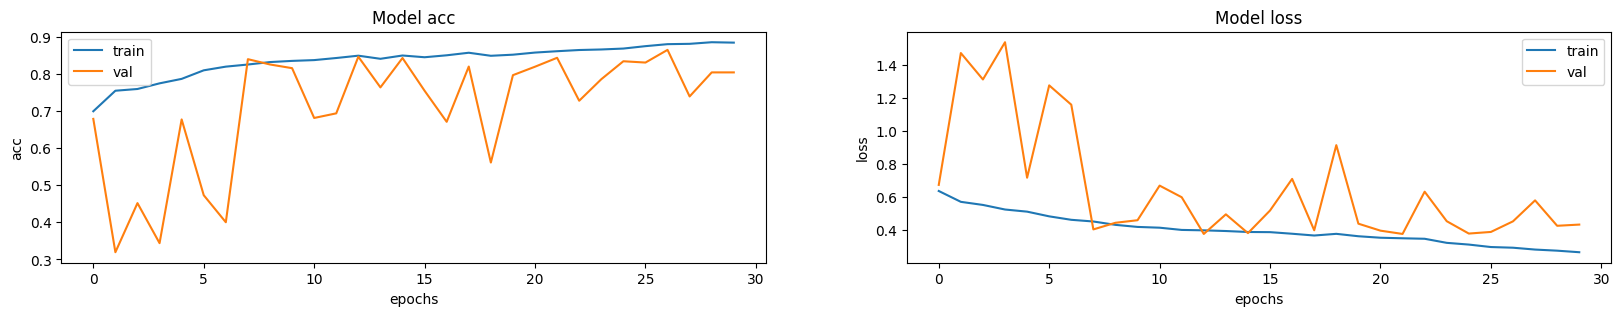

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

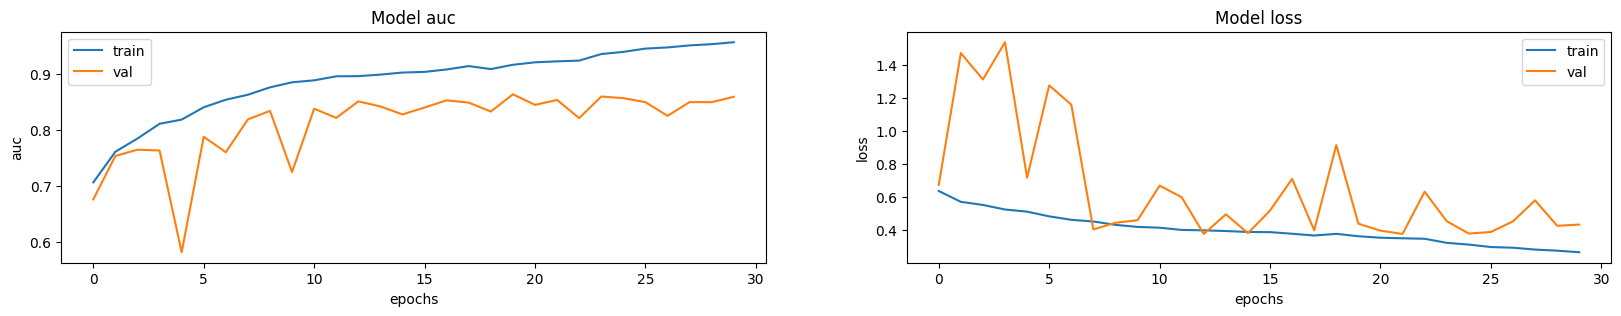

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [153]:
model.evaluate(X_test, y_test) 

152/152 [==============================] - 3s 22ms/step - loss: 0.4542 - acc: 0.7954 - auc: 0.8611 - weighted_acc: 0.7954


[0.4541500508785248,
 0.7954358458518982,
 0.8611499071121216,
 0.7954358458518982]

In [154]:
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy score:', score[1])
print('Test roc auc score:', score[2])
print('Test weighted accuracy score:', score[3])

Test loss: 0.4541500508785248
Test accuracy score: 0.7954358458518982
Test roc auc score: 0.8611499071121216
Test weighted accuracy score: 0.7954358458518982


In [155]:
pred = model.predict(X_test)
print(pred)

152/152 [==============================] - 4s 21ms/step
[[0.6078963 ]
 [0.3828356 ]
 [0.67557997]
 ...
 [0.35312024]
 [0.09536308]
 [0.437389  ]]


In [156]:
importlib.reload(results_functions)
from results_functions import *

In [157]:
list_patient_rows = list(df_test.groupby(['patient_id'])['patient_id'].count())

In [158]:
pred_groupby_patient = np.split(pred,cumulative(list_patient_rows))
pred_groupby_patient = pred_groupby_patient[:-1]

df_test = df_test.astype({'murmur':'int'})
y_test_grouped = df_test[['patient_id','murmur']].drop_duplicates()['murmur'].to_list()

In [159]:
pred1 = mean_pred(pred_groupby_patient)
pred2 = majority_pred(pred_groupby_patient)

In [160]:
print(pred1)
print(pred2)
print(y_test_grouped)
print("Accuracy score of mean_pred : ",accuracy_score(pred1 , y_test_grouped))
print("Accuracy score of majority_pred : ",accuracy_score(pred2 , y_test_grouped))

[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

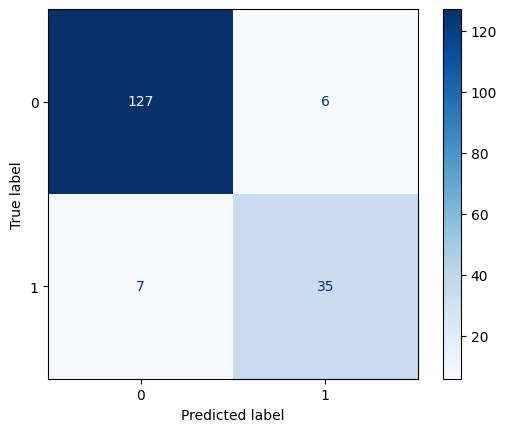

In [161]:
ConfusionMatrixDisplay.from_predictions(y_test_grouped, pred2,
                                        cmap='Blues', normalize = None)

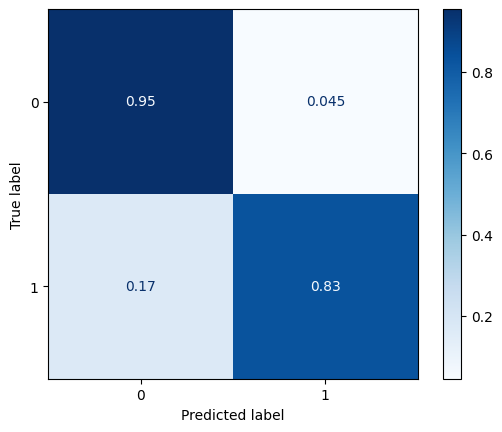

In [162]:
ConfusionMatrixDisplay.from_predictions(y_test_grouped, pred2,
                                        cmap='Blues', normalize = 'true')